In [1]:
source('../load_environment.R')
options(repr.plot.width=8, repr.plot.height=4)

Pivot Bio, Inc.
This code performs analyses supporting findings of the paper entitled:
"Genetic remodeling of soil diazotrophs enables partial replacement of synthetic nitrogen fertilizer with biological nitrogen fixation in maize".

##------ Thu Jun 06 09:58:14 2024 ------## 
Loaded packages:  tidyverse, readxl, broom, foreach, nlme, lme4, lmerTest, glmmTMB, car, DHARMa, caret, emmeans, multcomp, ggpubr, scales, png, ggthemes and their dependencies.
A complete list of packages used in the analysis is provided in the `packages_citations.txt` file.


## Prepare data

In [2]:
qpcr <- read_csv("./datasets/pivot_bio_trials_qpcr.csv", col_types = "cccccn")  #%>% filter(formulation != "F1", rate %in% c("0","1e3","1e5"))

# Recode factors
qpcr <- qpcr %>% mutate_at(c("trial","rep","rate","target_strain"), factor)
qpcr$rate_num <- as.numeric(as.character(qpcr$rate))
qpcr$rate_ord <- ordered(qpcr$rate)
qpcr$trt <- factor(qpcr$trt, levels = c('UTC','PROVEN40'), labels = c('Uninoculated Control','PROVEN 40'))
qpcr$target_strain <- factor(qpcr$target_strain, levels = c('6-5687','137-2253'), labels = c('Ks6-5687','Kv137-2253'))

summary(qpcr)

     trial     rep     rate                       trt         target_strain
 IA03451: 60   1:89   0  :106   Uninoculated Control:106   Ks6-5687  :267  
 IL01451: 60   2:90   1e2:108   PROVEN 40           :429   Kv137-2253:268  
 IL03451: 60   3:90   1e3:107                                              
 IN01451: 60   4:88   1e4:108                                              
 IN02451: 60   5:88   1e5:106                                              
 MI01451: 60   6:90                                                        
 (Other):175                                                               
 copies_per_g_fw      rate_num      rate_ord 
 Min.   :      0   Min.   :     0   0  :106  
 1st Qu.:     12   1st Qu.:   100   1e2:108  
 Median :    377   Median :  1000   1e3:107  
 Mean   :  38913   Mean   : 22052   1e4:108  
 3rd Qu.:   8059   3rd Qu.: 10000   1e5:106  
 Max.   :4706016   Max.   :100000            
                                             

## First try

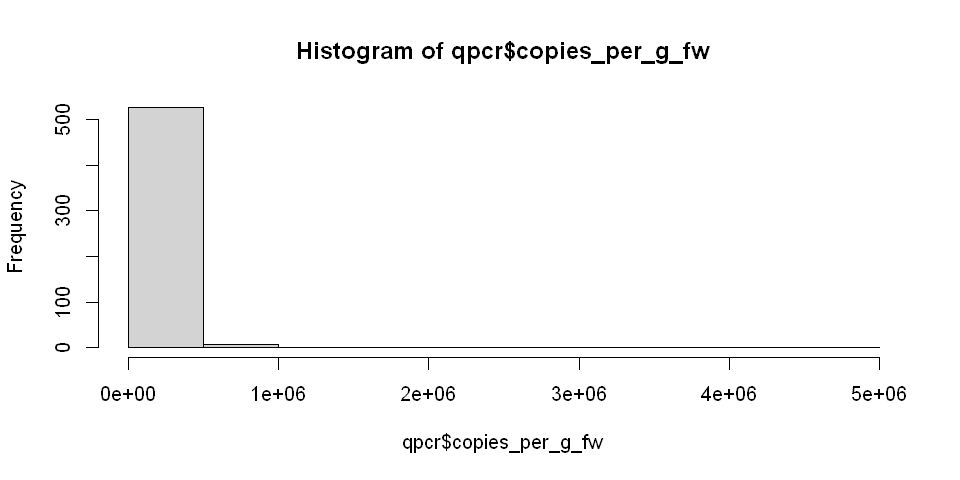

In [3]:
hist(qpcr$copies_per_g_fw)

## Model terms
- `rate` = Fixed effect of inoculation rate
- `target_strain` = fixed effect of the target strain is the primer looking for
- `1|trial/rep/rate` = Random effect of the plot within the rep within the trial (note: 2 plants were sampled from each plot)

In [4]:
qpcr_mod_1 <- lmer(copies_per_g_fw ~ rate*target_strain + (1|trial/rep), data = qpcr)

Warning message in asinh(z):
"NaNs produced"
Warning message in asinh(z):
"NaNs produced"
Warning message in asinh(z):
"NaNs produced"
Warning message in asinh(z):
"NaNs produced"
Warning message in asinh(z):
"NaNs produced"
Warning message in asinh(z):
"NaNs produced"


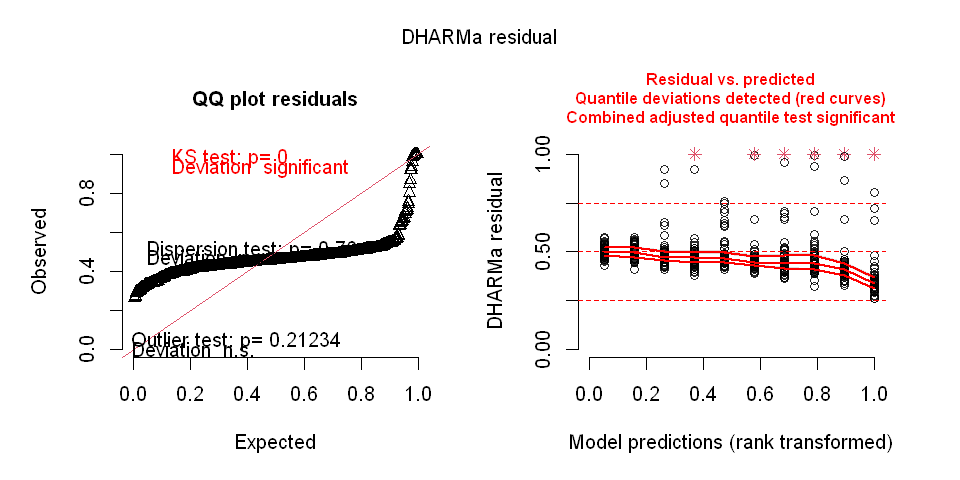

In [5]:
qpcr_mod_1_sims  <- simulateResiduals(fittedModel = qpcr_mod_1, plot = T)

### Lots of issues:

- Lots of zeroes
- High variance

Consider a log transformation to deal with high variance. Becasue of the zeores in the data we'll use:

`log(y + 1)`

This will keep the zeroes intact. 

## Model 2

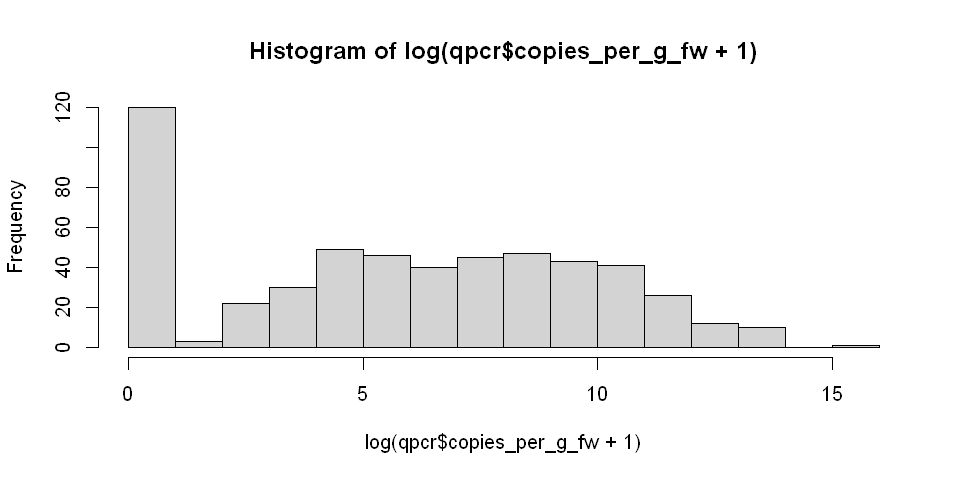

In [6]:
hist(log(qpcr$copies_per_g_fw+1))

In [7]:
qpcr_mod_2 <- lmer(log(copies_per_g_fw + 1) ~ rate*target_strain + (1|trial/rep), data = qpcr)

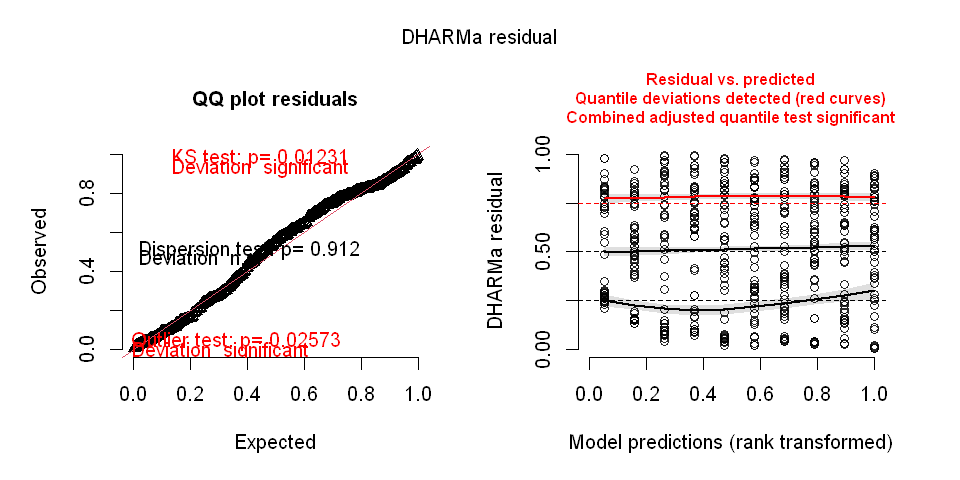

In [8]:
qpcr_mod_2_sims  <- simulateResiduals(fittedModel = qpcr_mod_2, plot = T)


	DHARMa zero-inflation test via comparison to expected zeros with
	simulation under H0 = fitted model

data:  simulationOutput
ratioObsSim = Inf, p-value < 2.2e-16
alternative hypothesis: two.sided


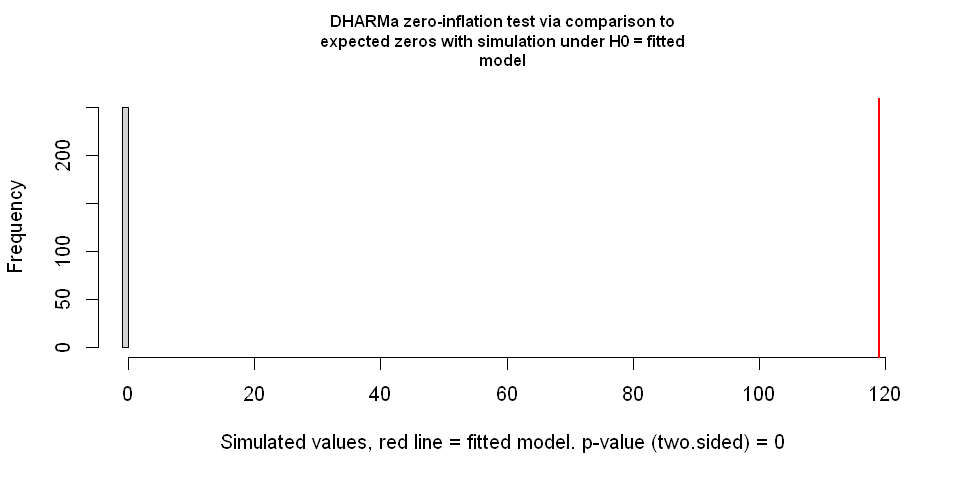

In [9]:
testZeroInflation(qpcr_mod_2)

OK, better. But still have the issue with the zero-inflation. 

## Model 3

Try to fit a zero-inflated model to deal with this. 

A zero-inflated model adds structural zeros to allow for the higher number of zeros than expected by a normal distribution. 

The probability of having a structural zero is always modeled with a logit link to keep it between 0 and 1, i.e.

`logit(p)=β0+ β1x + ... + β1n`

where p is the probability of having a structural zero. 

Will use `glmmTMB` to acomplisht this. More about  glmmTMB here: https://rpubs.com/mmcgillycuddy/737181


In [10]:
qpcr_mod_3 <- glmmTMB(log(copies_per_g_fw + 1) ~ rate*target_strain + (1|trial/rep),
                        zi=~., # This is the zero-inflated model specification. For now, we keep the same as the conditional model
                        #dispformula = ~  rate, # ErrVar = 0
                        family = "gaussian",
                        data = qpcr)

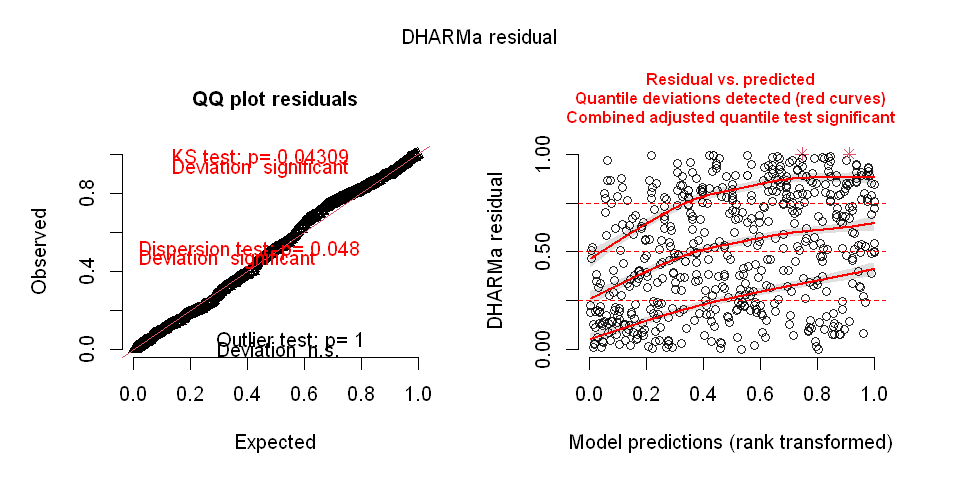

In [11]:
qpcr_mod_3_sims  <- simulateResiduals(fittedModel = qpcr_mod_3, plot = T)


	DHARMa zero-inflation test via comparison to expected zeros with
	simulation under H0 = fitted model

data:  simulationOutput
ratioObsSim = 1.002, p-value = 0.984
alternative hypothesis: two.sided


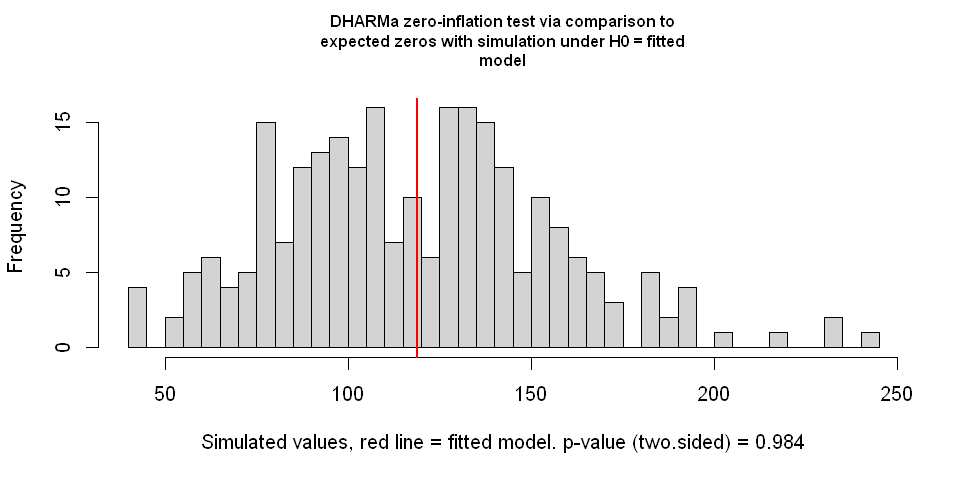

In [12]:
testZeroInflation(qpcr_mod_3)

In [13]:
BIC(qpcr_mod_2,qpcr_mod_3)

,df,BIC
,<dbl>,<dbl>
qpcr_mod_2,13,2725.036
qpcr_mod_3,25,2365.911


This model helped with dealing with the zero-infation, but it the residuals still appear a bit overdispersed (i.e., residual variance is larger than expected under the fitted model), particularly in the 3rd and 4th quartilies of the data.

If overdispersion is present, confidence intervals tend to be too narrow, and p-values to small, leading to inflated type I error. 


## Model 4
One possible reason for overdispersion is that the model might be overparameterized. Try relaxing the zero inflation model by only making it dependent on fixed effects.   

In [14]:
qpcr_mod_4 <- glmmTMB(log(copies_per_g_fw + 1) ~ rate*target_strain + (1|trial/rep),
                        zi = ~  rate*target_strain, 
                        family = "gaussian",
                        data = qpcr)

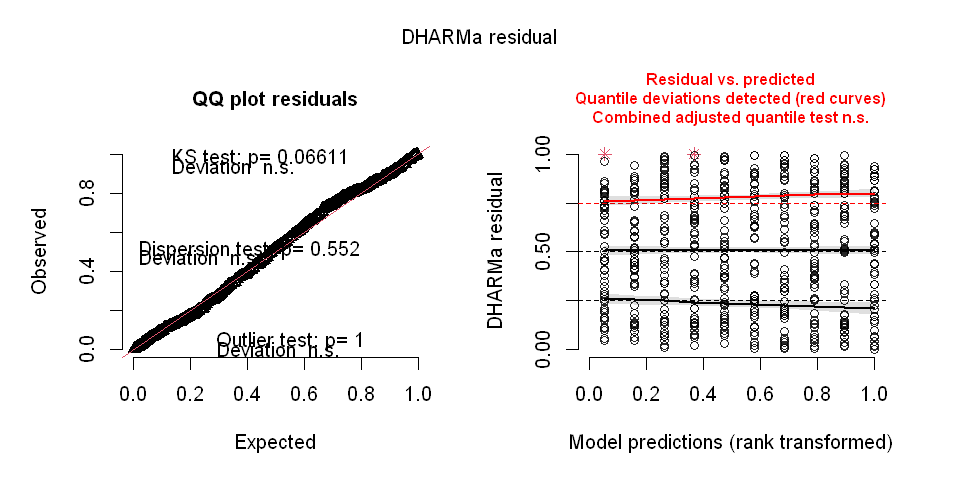

In [15]:
qpcr_mod_4_sims  <- simulateResiduals(fittedModel = qpcr_mod_4, plot = T)

In [16]:
anova(qpcr_mod_3,qpcr_mod_4)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
qpcr_mod_4,23,2369.281,2467.773,-1161.640,2323.281,NA,NA,NA
qpcr_mod_3,25,2258.854,2365.911,-1104.427,2208.854,114.4271,2,1.420595e-25


In [17]:
VarCorr(qpcr_mod_3)


Conditional model:
 Groups    Name        Std.Dev.
 rep:trial (Intercept) 0.62981 
 trial     (Intercept) 1.71054 
 Residual              2.03648 

Zero-inflation model:
 Groups    Name        Std.Dev.
 rep:trial (Intercept) 0.42657 
 trial     (Intercept) 1.84296 
 Residual              2.03648 

In [18]:
VarCorr(qpcr_mod_4)


Conditional model:
 Groups    Name        Std.Dev.
 rep:trial (Intercept) 0.65765 
 trial     (Intercept) 1.71852 
 Residual              2.03670 

The more relaxed model `qpcr_mod_4` seemed to have helped with the lingering overdispersion. However, the fit to the data was significanlty reduced. Plus, there is reason to believe that zero data should also be driven my environmental contrains and not solely technical (e.g., specificity of the primers). So there appears to be risk of underfitting the data. 

## Model 5

We might be able to deal with the overdispersion instead by modeling the variance as a function of our predictors.We begin to check whether there is significantly different variances among groups of data

In [19]:
# test for HOV across treatments
leveneTest(log(copies_per_g_fw + 1) ~ rate, data=qpcr)
leveneTest(log(copies_per_g_fw + 1) ~ target_strain, data=qpcr)
leveneTest(log(copies_per_g_fw + 1) ~ trial, data=qpcr)
leveneTest(log(copies_per_g_fw + 1) ~ paste0(trial,rep), data=qpcr)

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,4,4.657246,0.001057207
,530,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,5.73698,0.01695545
,533,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,8,1.422206,0.1842012
,526,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
"group coerced to factor."


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,53,0.8425124,0.7770381
,481,NA,NA


There seems to be diffences in variance between rates and strains. We add the model via the `dispformula` argument. 

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
qpcr_mod_3,25,2258.854,2365.911,-1104.427,2208.854,NA,NA,NA
qpcr_mod_5,30,2265.364,2393.832,-1102.682,2205.364,3.490318,5,0.6248532


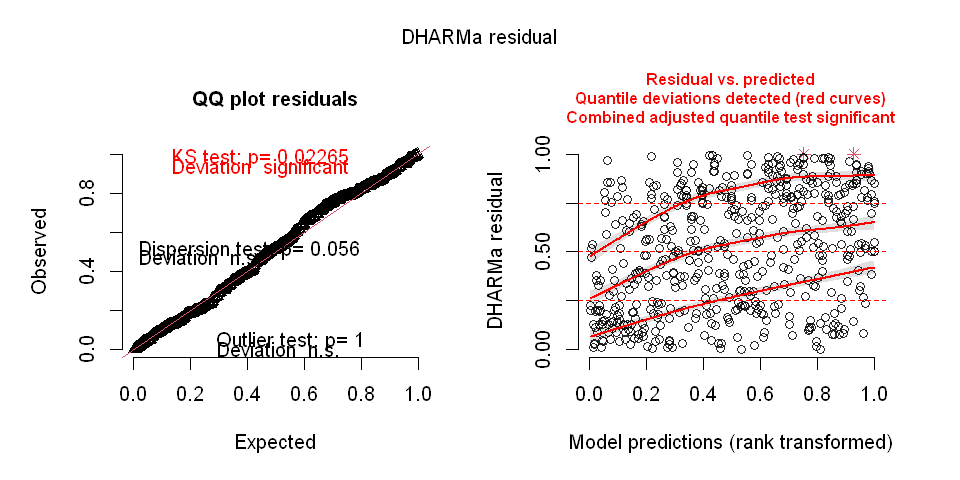

In [20]:
qpcr_mod_5 <- glmmTMB(log(copies_per_g_fw + 1) ~ rate*target_strain + (1|trial/rep),
                        zi=~., # This is the zero-inflated model specification. For now, we keep the same as the conditional model
                        dispformula  = ~ rate + target_strain,
                        family = "gaussian",
                        data = qpcr)

qpcr_mod_5_sims  <- simulateResiduals(fittedModel = qpcr_mod_5, plot = T)
anova(qpcr_mod_5,qpcr_mod_3)

## Chosen model

While `qpcr_mod_5` appears to be a bit overparemeterized without significant gain in the fit, the overdispersion seemed to be resolved. Thus we move ahead with this model.



In [21]:
qpcr_mod <- qpcr_mod_5
summary(qpcr_mod)

 Family: gaussian  ( identity )
Formula:          
log(copies_per_g_fw + 1) ~ rate * target_strain + (1 | trial/rep)
Zero inflation:                            ~.
Dispersion:                                ~rate + target_strain
Data: qpcr

     AIC      BIC   logLik deviance df.resid 
  2265.4   2393.8  -1102.7   2205.4      505 

Random effects:

Conditional model:
 Groups    Name        Variance Std.Dev.
 rep:trial (Intercept) 0.4516   0.672   
 trial     (Intercept) 3.1743   1.782   
 Residual                  NA      NA   
Number of obs: 535, groups:  rep:trial, 54; trial, 9

Zero-inflation model:
 Groups    Name        Variance Std.Dev.
 rep:trial (Intercept) 0.1809   0.4253  
 trial     (Intercept) 3.3853   1.8399  
 Residual                  NA       NA  
Number of obs: 535, groups:  rep:trial, 54; trial, 9

Conditional model:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      5.23612    0.77734   6.736 1.63e-11 ***
rate1e2 

Note: The zero-inflation model estimates the probability of an extra zero, so `Estimate <0` indicates fewer absences (i.e., zeroes)
 

The zero-inflation model estimates the probability of an extra zero, so `Estimate <0` indicates fewer absences (i.e., zeroes)

In [22]:
VarCorr(qpcr_mod)


Conditional model:
 Groups    Name        Std.Dev.
 rep:trial (Intercept) 0.67201 
 trial     (Intercept) 1.78167 
 Residual                   NA 

Zero-inflation model:
 Groups    Name        Std.Dev.
 rep:trial (Intercept) 0.4253  
 trial     (Intercept) 1.8399  
 Residual                  NA  

In [23]:
qpcr_mod_zi_means <- emmeans(qpcr_mod,  trt.vs.ctrl ~ rate|target_strain, component = "zi", type = "response")

In [24]:
qpcr_mod_zi_means$emmeans

target_strain = Ks6-5687:
 rate response      SE  df lower.CL upper.CL
 0       0.628 0.11217 505    0.458    0.840
 1e2     0.505 0.07895 505    0.407    0.710
 1e3     0.437 0.04673 505    0.385    0.592
 1e4     0.422 0.03798 505    0.381    0.557
 1e5     0.400 0.02435 505    0.375    0.498

target_strain = Kv137-2253:
 rate response      SE  df lower.CL upper.CL
 0       0.417 0.03548 505    0.379    0.547
 1e2     0.387 0.01531 505    0.372    0.454
 1e3     0.383 0.01251 505    0.371    0.440
 1e4     0.374 0.00552 505    0.369    0.404
 1e5     0.381 0.01125 505    0.370    0.434

Confidence level used: 0.95 
Intervals are back-transformed from the log[logit(mu + 1)] scale 

In [25]:
qpcr_mod_zi_means$contrasts

target_strain = Ks6-5687:
 contrast        odds.ratio     SE  df null t.ratio p.value
 rate1e2 / rate0       1.49 0.3012 505 2.72  -1.817  0.2147
 rate1e3 / rate0       1.20 0.1175 505 2.72  -3.138  0.0068
 rate1e4 / rate0       1.15 0.0876 505 2.72  -3.605  0.0013
 rate1e5 / rate0       1.08 0.0514 505 2.72  -4.261  0.0001

target_strain = Kv137-2253:
 contrast        odds.ratio     SE  df null t.ratio p.value
 rate1e2 / rate0       1.45 0.3493 505 2.72  -1.527  0.3555
 rate1e3 / rate0       1.34 0.2637 505 2.72  -1.830  0.2098
 rate1e4 / rate0       1.12 0.0999 505 2.72  -2.718  0.0247
 rate1e5 / rate0       1.29 0.2295 505 2.72  -1.962  0.1609

P value adjustment: dunnettx method for 4 tests 
Tests are performed on the log[log odds ratio] scale 

In [26]:
# Expected marginal means from the conditional model
qpcr_mod_cond_means <- emmeans(qpcr_mod,  trt.vs.ctrl ~ rate|target_strain,  component = "cond", type ="response")

In [27]:
qpcr_mod_cond_means$emmeans

target_strain = Ks6-5687:
 rate response   SE  df lower.CL upper.CL
 0         187  146 505     39.8      865
 1e2      1096  771 505    274.8     4361
 1e3       464  327 505    116.0     1851
 1e4      2491 1743 505    629.3     9850
 1e5      2904 1988 505    756.3    11141

target_strain = Kv137-2253:
 rate response   SE  df lower.CL upper.CL
 0         179  125 505     45.4      700
 1e2      1435  942 505    394.8     5209
 1e3      1144  758 505    310.9     4205
 1e4      2899 1923 505    787.3    10671
 1e5      4635 3064 505   1264.0    16987

Confidence level used: 0.95 
Intervals are back-transformed from the log(mu + 1) scale 

In [28]:
qpcr_mod_cond_means$contrasts

target_strain = Ks6-5687:
 contrast        ratio    SE  df null t.ratio p.value
 rate1e2 / rate0  5.84  3.52 505    1   2.923  0.0135
 rate1e3 / rate0  2.48  1.50 505    1   1.497  0.3724
 rate1e4 / rate0 13.26  7.98 505    1   4.292  0.0001
 rate1e5 / rate0 15.46  9.06 505    1   4.672  <.0001

target_strain = Kv137-2253:
 contrast        ratio    SE  df null t.ratio p.value
 rate1e2 / rate0  7.96  3.42 505    1   4.822  <.0001
 rate1e3 / rate0  6.35  2.78 505    1   4.215  0.0001
 rate1e4 / rate0 16.08  7.10 505    1   6.289  <.0001
 rate1e5 / rate0 25.69 11.21 505    1   7.442  <.0001

P value adjustment: dunnettx method for 4 tests 
Tests are performed on the log scale 

## Add output from the zero inflation model

In [29]:
qpcr_mod_cond_means_table <- data.frame(qpcr_mod_cond_means$contrasts) %>% 
    transmute(target_strain, rate = substr(contrast,5,7),
    plab = ifelse(p.value < 0.001,"p<0.001",paste0("p=",signif(p.value,2)))) %>% 
    full_join(data.frame(qpcr_mod_cond_means$emmeans)) %>%
left_join(qpcr %>% dplyr::select(rate,trt) %>% unique)# %>% 

qpcr_mod_cond_means_table

qpcr_mod_zi_means_table <- data.frame(qpcr_mod_zi_means$contrasts) %>% 
    transmute(target_strain, rate = substr(contrast,5,7),
    plab = ifelse(p.value < 0.001,"p<0.001",paste0("p=",signif(p.value,2)))) %>% 
    full_join(data.frame(qpcr_mod_zi_means$emmeans)) %>%
left_join(qpcr %>% dplyr::select(rate,trt) %>% unique)# %>% 

qpcr_mod_zi_means_table

Joining with `by = join_by(target_strain, rate)`
Joining with `by = join_by(rate)`


target_strain,rate,plab,response,SE,df,lower.CL,upper.CL,trt
<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Ks6-5687,1e2,p=0.013,1095.9177,770.7137,505,274.84683,4360.9438,PROVEN 40
Ks6-5687,1e3,p=0.37,464.3998,327.1464,505,115.96296,1850.8424,PROVEN 40
Ks6-5687,1e4,p<0.001,2490.6707,1743.3028,505,629.25299,9849.6839,PROVEN 40
Ks6-5687,1e5,p<0.001,2903.7004,1987.6225,505,756.25749,11140.8967,PROVEN 40
Kv137-2253,1e2,p<0.001,1435.0476,942.0094,505,394.78708,5209.4600,PROVEN 40
Kv137-2253,1e3,p<0.001,1144.3423,758.2797,505,310.91703,4204.6340,PROVEN 40
Kv137-2253,1e4,p<0.001,2899.4858,1923.2179,505,787.33485,10670.6303,PROVEN 40
Kv137-2253,1e5,p<0.001,4634.7345,3064.3567,505,1264.02047,16986.8942,PROVEN 40
Ks6-5687,0,NA,186.9404,146.0943,505,39.80886,864.5374,Uninoculated Control


Joining with `by = join_by(target_strain, rate)`
Joining with `by = join_by(rate)`


target_strain,rate,plab,response,SE,df,lower.CL,upper.CL,trt
<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Ks6-5687,1e2,p=0.21,0.5046660,0.078951189,505,0.4067163,0.7096622,PROVEN 40
Ks6-5687,1e3,p=0.0068,0.4365144,0.046728756,505,0.3847097,0.5923181,PROVEN 40
Ks6-5687,1e4,p=0.0013,0.4224906,0.037981882,505,0.3810757,0.5565468,PROVEN 40
Ks6-5687,1e5,p<0.001,0.4002901,0.024345823,505,0.3750405,0.4975737,PROVEN 40
Kv137-2253,1e2,p=0.36,0.3871222,0.015311283,505,0.3718247,0.4543735,PROVEN 40
Kv137-2253,1e3,p=0.21,0.3831576,0.012514047,505,0.3708825,0.4404289,PROVEN 40
Kv137-2253,1e4,p=0.025,0.3736981,0.005524513,505,0.3687730,0.4043904,PROVEN 40
Kv137-2253,1e5,p=0.16,0.3812302,0.011246633,505,0.3703902,0.4344572,PROVEN 40
Ks6-5687,0,NA,0.6282632,0.112167777,505,0.4581439,0.8395180,Uninoculated Control


In [30]:
names(qpcr_mod_cond_means_table) <- gsub("asymp.L","lower.",names(qpcr_mod_cond_means_table))
names(qpcr_mod_cond_means_table) <- gsub("asymp.U","upper.",names(qpcr_mod_cond_means_table))
names(qpcr_mod_cond_means_table) <- gsub("emmean","response",names(qpcr_mod_cond_means_table))

names(qpcr_mod_zi_means_table) <- gsub("asymp.L","lower.",names(qpcr_mod_zi_means_table))
names(qpcr_mod_zi_means_table) <- gsub("asymp.U","upper.",names(qpcr_mod_zi_means_table))
names(qpcr_mod_zi_means_table) <- gsub("emmean","response",names(qpcr_mod_zi_means_table))

In [31]:
p1 <- qpcr_mod_cond_means_table %>% 
mutate(model = "Conditional model") %>% 
ggplot(aes(x = as.numeric(as.factor(rate)),response, fill = target_strain)) + 
facet_wrap(~model, scales = "free") +
geom_col(colour = "gray10", width = 0.5, aes(), position = "dodge") + 
geom_errorbar(aes(ymax = upper.CL, ymin = lower.CL), width = 0.3, position = position_dodge(width = 0.5)) + 
geom_text(aes(label = plab, y = upper.CL*1.5), hjust = 0.85, size = 2.5, position = position_dodge(width = 0.5)) + 
scale_y_log10(breaks = c(10,100,1000,10000,100000)) +
coord_cartesian(ylim  = c(10,100000), xlim = c(0.3,5.8), expand = F) +
scale_fill_manual(values = myColorPalette) +
scale_x_continuous(breaks = 1:5, labels=parse(text=c("0","10^2","10^3","10^4","10^5"))) + 
labs(y = "Copies per g of root fresh weight", x = "Inoculation rate (CFU per seed)", fill = "Primer strain target:") + 
theme(axis.text.x = element_text(vjust = 0)) 

In [32]:
p2 <- qpcr_mod_zi_means_table %>% 
mutate(model = "Zero-inflation model") %>% 
ggplot(aes(x = as.numeric(as.factor(rate)),response, fill = target_strain)) + 
facet_wrap(~model, scales = "free") +
geom_col(colour = "gray10", width = 0.5, aes(), position = "dodge") + 
geom_errorbar(aes(ymax = upper.CL, ymin = lower.CL), width = 0.3, position = position_dodge(width = 0.5)) + 
geom_text(aes(label = plab, y = upper.CL + 0.05), hjust = 0.15, size = 2.5, position = position_dodge(width = 0.5)) + 
coord_cartesian(ylim  = c(0,1), xlim = c(0.3,5.8), expand = F) +
scale_fill_manual(values = myColorPalette) +
scale_x_continuous(breaks = 1:5, labels=parse(text=c("0","10^2","10^3","10^4","10^5"))) + 
labs(y = "Prob. of zero copies", x = "Inoculation rate (CFU per seed)", fill = "Primer strain target:") + 
theme(axis.text.x = element_text(vjust = 0)) 

Warning message:
"Removed 2 rows containing missing values (`geom_text()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_text()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_text()`)."


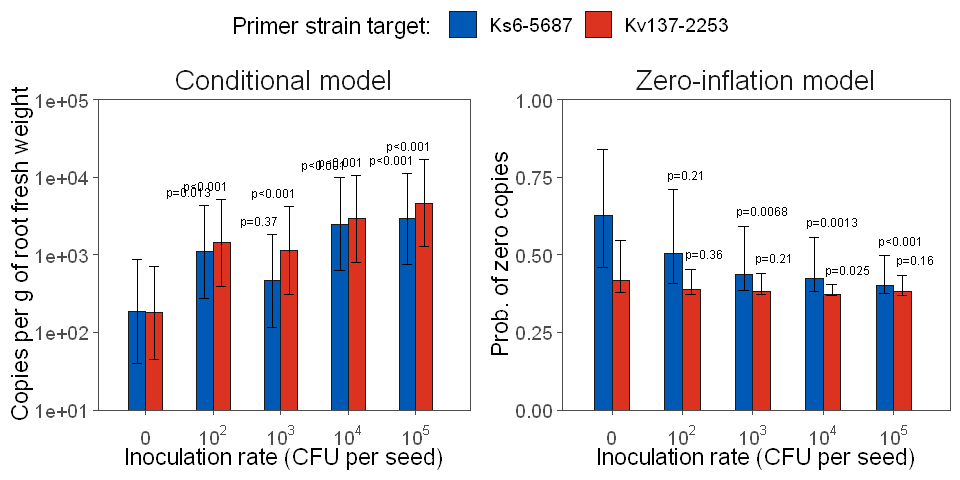

In [33]:
options(repr.plot.width=8, repr.plot.height=4)

ggarrange(p1,p2, common.legend = TRUE)

In [34]:
qpcr_mod_comb_means <- emmeans(qpcr_mod,  trt.vs.ctrl ~ rate|target_strain, component = "response", type= "response")

Warning message in checkTerms(data.tmb1$terms, data.tmb0$terms):
"Predicting new random effect levels for terms: 1 | rep:trial
Disable this warning with 'allow.new.levels=TRUE'"
Warning message in checkTerms(data.tmb1$termszi, data.tmb0$termszi):
"Predicting new random effect levels for terms: 1 | rep:trial
Disable this warning with 'allow.new.levels=TRUE'"


In [35]:
qpcr_mod_comb_means$emmeans

target_strain = Ks6-5687:
 rate response   SE  df lower.CL upper.CL
 0        10.4   13 505    0.211      106
 1e2     119.0  163 505    7.358     1721
 1e3     161.7  154 505   24.441     1040
 1e4     843.1  849 505  116.060     6085
 1e5    1480.5 1234 505  287.467     7607

target_strain = Kv137-2253:
 rate response   SE  df lower.CL upper.CL
 0        92.6   73 505   19.237      432
 1e2     990.3  694 505  249.321     3925
 1e3     858.9  589 505  223.023     3300
 1e4    2558.4 1700 505  692.782     9441
 1e5    3430.1 2385 505  874.397    13447

Confidence level used: 0.95 
Intervals are back-transformed from the log(mu + 1) scale 

In [36]:
qpcr_mod_comb_means$contrasts

target_strain = Ks6-5687:
 contrast         ratio     SE  df null t.ratio p.value
 rate1e2 / rate0  10.52   8.45 505    1   2.931  0.0131
 rate1e3 / rate0  14.27  11.17 505    1   3.398  0.0028
 rate1e4 / rate0  74.03  58.68 505    1   5.431  <.0001
 rate1e5 / rate0 129.94 113.78 505    1   5.558  <.0001

target_strain = Kv137-2253:
 contrast         ratio     SE  df null t.ratio p.value
 rate1e2 / rate0  10.59   5.37 505    1   4.654  <.0001
 rate1e3 / rate0   9.19   4.86 505    1   4.187  0.0001
 rate1e4 / rate0  27.34  16.01 505    1   5.649  <.0001
 rate1e5 / rate0  36.65  19.41 505    1   6.800  <.0001

P value adjustment: dunnettx method for 4 tests 
Tests are performed on the log scale 

In [37]:
qpcr_mod_comb_means_table <- data.frame(qpcr_mod_comb_means$contrasts) %>% 
    transmute(target_strain, rate = substr(contrast,5,7),
    plab = ifelse(p.value < 0.001,"p<0.001",paste0("p=",signif(p.value,2)))) %>% 
    full_join(data.frame(qpcr_mod_comb_means$emmeans)) %>%
left_join(qpcr %>% dplyr::select(rate,trt) %>% unique)# %>% 


Joining with `by = join_by(target_strain, rate)`
Joining with `by = join_by(rate)`


In [38]:
names(qpcr_mod_comb_means_table) <- gsub("asymp.L","lower.",names(qpcr_mod_comb_means_table))
names(qpcr_mod_comb_means_table) <- gsub("asymp.U","upper.",names(qpcr_mod_comb_means_table))
names(qpcr_mod_comb_means_table) <- gsub("emmean|estimate","response",names(qpcr_mod_comb_means_table))

In [39]:
qpcr_mod_comb_means_table

target_strain,rate,plab,response,SE,df,lower.CL,upper.CL,trt
<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Ks6-5687,1e2,p=0.013,118.96341,162.66159,505,7.3581306,1720.8229,PROVEN 40
Ks6-5687,1e3,p=0.0028,161.72398,153.69900,505,24.4406221,1039.8194,PROVEN 40
Ks6-5687,1e4,p<0.001,843.06537,848.73492,505,116.0601976,6085.1536,PROVEN 40
Ks6-5687,1e5,p<0.001,1480.48274,1233.80911,505,287.4665599,7607.4767,PROVEN 40
Kv137-2253,1e2,p<0.001,990.28828,694.40071,505,249.3214094,3924.5630,PROVEN 40
Kv137-2253,1e3,p<0.001,858.93169,588.74858,505,223.0228800,3299.9241,PROVEN 40
Kv137-2253,1e4,p<0.001,2558.37810,1700.49343,505,692.7823968,9440.6006,PROVEN 40
Kv137-2253,1e5,p<0.001,3430.06005,2385.45835,505,874.3974098,13446.8044,PROVEN 40
Ks6-5687,0,NA,10.40133,13.01318,505,0.2108267,106.3567,Uninoculated Control


Warning message:
"Removed 2 rows containing missing values (`geom_text()`)."


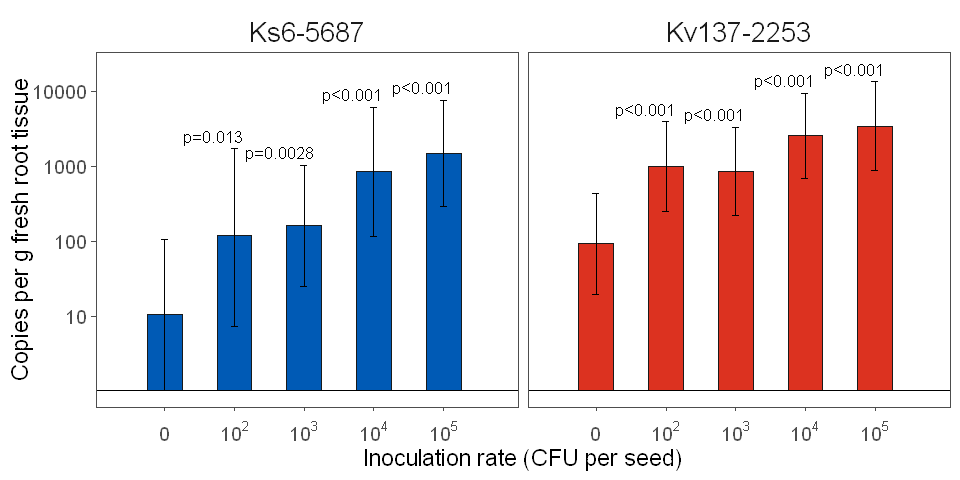

In [40]:
options(repr.plot.width=8, repr.plot.height=4)

qpcr_mod_comb_means_table %>% 
ggplot(aes(x = as.numeric(as.factor(rate)),response, fill = target_strain)) + 
geom_col(colour = "gray10", width = 0.5, aes(), position = "dodge") + 
geom_errorbar(aes(ymax = upper.CL, ymin = pmax(1,lower.CL)), width = 0.1, position = position_dodge(width = 0.5)) + 
geom_text(aes(label = plab, y = upper.CL*1.5), hjust = 0.85, size = 3.5, position = position_dodge(width = 0.5)) + 
geom_hline(yintercept = 1) + 
scale_y_log10(breaks = c(10,100,1000,10000,100000)) +
coord_cartesian(#ylim  = c(1,100000), 
xlim = c(0.3,5.8), expand = T) +
scale_fill_manual(values = myColorPalette) +
scale_x_continuous(breaks = 1:5, labels=parse(text=c("0","10^2","10^3","10^4","10^5"))) + 
facet_wrap(~target_strain) + 
labs(y = "Copies per g fresh root tissue", x = "Inoculation rate (CFU per seed)") + 
theme(axis.text.x = element_text(vjust = 0), legend.position = "none") 

#ggsave("./figures/strain_colonization.jpeg",width = 8, height = 4)

Warning message in geom_col(colour = "gray10", width = 0.5, aes(shape = target_strain), :
"Ignoring unknown aesthetics: shape"


Warning message:
"Removed 2 rows containing missing values (`geom_text()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_text()`)."


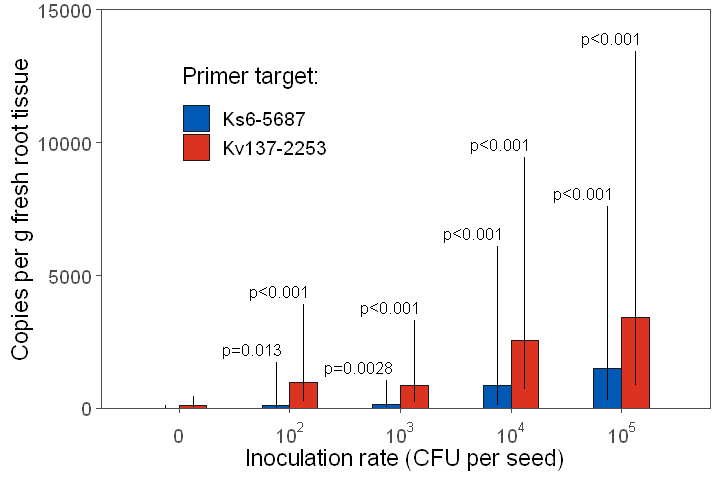

In [41]:
options(repr.plot.width=6, repr.plot.height=4)

qpcr_mod_comb_means_table %>% 
ggplot(aes(x = as.numeric(as.factor(rate)),response, fill = target_strain)) + 
geom_col(colour = "gray10", width = 0.5, aes(shape = target_strain), position = position_dodge(width = 0.5)) + 
geom_errorbar(aes(ymax = upper.CL, ymin = pmax(1,lower.CL)), width = 0, position = position_dodge(width = 0.5)) + 
geom_text(aes(label = plab, y = upper.CL + 500), hjust = 0.9, size = 3.5, position = position_dodge(width = 0.5)) + 
geom_hline(yintercept = 1) + 
#scale_y_log10(breaks = c(1,10,100,1000,10000,100000)) +
coord_cartesian(ylim  = c(0,ceiling(max(qpcr_mod_comb_means_table$upper.CL + 1000)/1000)*1000), 
xlim = c(0.3,5.8), expand = F) +
scale_fill_manual(values = myColorPalette) +
scale_shape_manual(values = c(21,23)) + 
scale_x_continuous(breaks = 1:5, labels=parse(text=c("0","10^2","10^3","10^4","10^5"))) + 
#facet_wrap(~target_strain) + 
labs(y = "Copies per g fresh root tissue", x = "Inoculation rate (CFU per seed)", fill = "Primer target:") + 
theme(axis.text.x = element_text(vjust = 0), legend.position = c(0.25,0.75)
) 

ggsave("./figures/strain_colonization.jpeg",width = 6, height = 4)


In [42]:
emmeans(qpcr_mod,  trt.vs.ctrl ~ target_strain, component = "response", type= "response")$contrast

Warning message in checkTerms(data.tmb1$terms, data.tmb0$terms):
"Predicting new random effect levels for terms: 1 | rep:trial
Disable this warning with 'allow.new.levels=TRUE'"
Warning message in checkTerms(data.tmb1$termszi, data.tmb0$termszi):
"Predicting new random effect levels for terms: 1 | rep:trial
Disable this warning with 'allow.new.levels=TRUE'"


 contrast                  ratio   SE  df null t.ratio p.value
 (Kv137-2253) / (Ks6-5687)  4.79 2.97 505    1   2.527  0.0118

Results are averaged over the levels of: rate 
Tests are performed on the log scale 

In [43]:
1/4.79 

[1] 0.2087683

## Check if there is evidence of increse with Inoculation rate

In [44]:
qpcr_lin_mod_1 <- glmmTMB(log(copies_per_g_fw + 1) ~ rate_num * target_strain  + (1|trial/rep),
                        zi=~.,
                        #dispformula  = ~ rate + target_strain,
                        family = "gaussian",
                        data = qpcr)

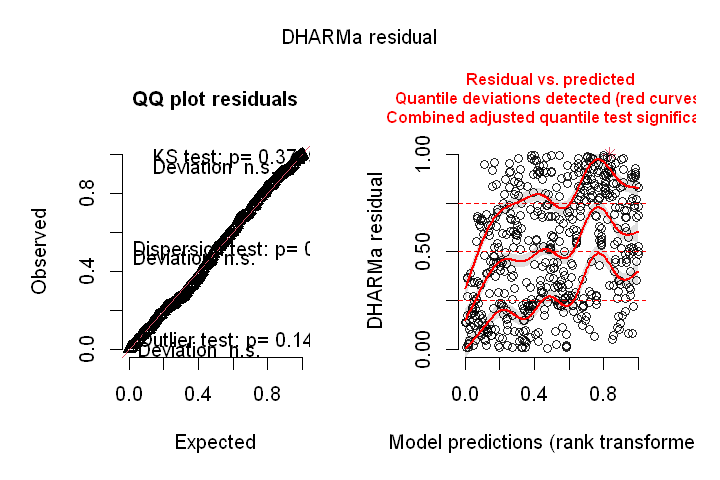

In [45]:
qpcr_lin_mod_1_sim  <- simulateResiduals(fittedModel = qpcr_lin_mod_1, plot = T)


In [46]:
Anova(qpcr_lin_mod_1,"III")
summary(qpcr_lin_mod_1)

Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"
Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"


,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
(Intercept),113.8630958,1,1.396232e-26
rate_num,12.5210018,1,4.024031e-04
target_strain,0.4792344,1,4.887693e-01
rate_num:target_strain,0.2689965,1,6.040057e-01


 Family: gaussian  ( identity )
Formula:          
log(copies_per_g_fw + 1) ~ rate_num * target_strain + (1 | trial/rep)
Zero inflation:                            ~.
Data: qpcr

     AIC      BIC   logLik deviance df.resid 
  2319.6   2375.2  -1146.8   2293.6      522 

Random effects:

Conditional model:
 Groups    Name        Variance Std.Dev.
 rep:trial (Intercept) 0.3346   0.5784  
 trial     (Intercept) 3.0766   1.7540  
 Residual              4.8721   2.2073  
Number of obs: 535, groups:  rep:trial, 54; trial, 9

Zero-inflation model:
 Groups    Name        Variance Std.Dev.
 rep:trial (Intercept) 0.09621  0.3102  
 trial     (Intercept) 2.81699  1.6784  
 Residual              4.87207  2.2073  
Number of obs: 535, groups:  rep:trial, 54; trial, 9

Dispersion estimate for gaussian family (sigma^2): 4.87 

Conditional model:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      6.688e+00  6.268e-01  10.671  < 2e-16 ***
rate_nu